# Sentence Classification


In this notebook, We will be classifying text (The data-set used here contains tweets, but the process shown here can be adapted for other text classification tasks too.)
The content is arranged as follows:
* Cleaninig and basic pre-processing of text
* Building a vocabulary, and creating iterators using TorchText
* Building a sequence model - LSTM using Pytorch to predict labels

**_Notebook is still under construction...._**


In [1]:
# Check the files in Data
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.100d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.50d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.200d.txt
/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/train.csv


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time

import torch
from torchtext import data
import torch.nn as nn


In [3]:
# Import Data

test = pd.read_csv("../input/nlp-getting-started/test.csv")
train = pd.read_csv("../input/nlp-getting-started/train.csv")

## **Data Pre Processing**
Cleaning the text data 

In [4]:
# Shape of dataset
train.shape

(7613, 5)

#### Let us get a glimpse at the data table

In [5]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


#### The `target` column marks the label of the text:
* **
* **label==1** : If the Tweet is about Disasters.
* **label==0** : If the Tweet is not about disasters. 

We are only interested in the `text` and `target` columns. So we drop the rest. 

In [6]:
# drop 'id' , 'keyword' and 'location' columns.
train.drop(columns=['id','keyword','location'], inplace=True)

### Next we clean and modify the texts, so that the classification algorithm does not get confused with irrelevant information. 

In [7]:
# to clean data
def normalise_text (text):
    text = text.str.lower() # lowercase
    text = text.str.replace(r"\#","") # replaces hashtags
    text = text.str.replace(r"http\S+","URL")  # remove URL addresses
    text = text.str.replace(r"@","")
    text = text.str.replace(r"[^A-Za-z0-9()!?\'\`\"]", " ")
    text = text.str.replace("\s{2,}", " ")
    return text

In [8]:
train["text"]=normalise_text(train["text"])

Let us look at the cleaned text once

In [9]:
train['text'].head()

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to 'shelter in place' are ...
3    13 000 people receive wildfires evacuation ord...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

Split the data into training and validation sets

In [10]:
# split data into train and validation 
train_df, valid_df = train_test_split(train)


In [11]:
train_df.head()

,text,target
433,local arsonist lmfao,0
5643,URL paci?c media centre articles australia rsf...,0
3994,there's this person amp they reckon when you'r...,0
5656,coastal german shepherd rescue oc shared a lin...,0
492,christian attacked by muslims at the temple mo...,1


In [12]:
valid_df.head()

,text,target
4993,2for1lapdances for the people who died in huma...,1
3860,maryland mansion fire that killed 6 caused by ...,1
2434,itsqueenbaby i'm at work it's a bunch of ppl a...,1
6489,the court s reputation and prestige has sunk e...,0
5143,salem 2 nuclear reactor shut down over electri...,1


The following will help make the results reproducible later.


In [13]:
SEED = 42

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False




We need to create `Field` objects to process the text data. These field objects will contain information for converting the texts to Tensors.
We will set two parameters:
* `tokenize=spacy` and 
* `include_arguments=True`
Which implies that SpaCy will be used to tokenize the texts and that the field objects should include length of the texts - which will be needed to pad the texts. 
We will later use methods of these objects to create a vocabulary, which will help us create a numerical representation for every token.

The `LabelField` is a shallow wrappper around field, useful for data labels. 

In [14]:
TEXT = data.Field(tokenize = 'spacy', include_lengths = True)
LABEL = data.LabelField(dtype = torch.float)

Next we create a `DataFrameDataset` class which will allow us to load the data and the target-labels as a `DataSet` using a DataFrame as a source of data.
We will create a vocabulary using the training dataset and then pass the training and validation datasets to the iterator later. 


In [15]:
# source : https://gist.github.com/lextoumbourou/8f90313cbc3598ffbabeeaa1741a11c8
# to use DataFrame as a Data source

class DataFrameDataset(data.Dataset):

    def __init__(self, df, fields, is_test=False, **kwargs):
        examples = []
        for i, row in df.iterrows():
            label = row.target if not is_test else None
            text = row.text
            examples.append(data.Example.fromlist([text, label], fields))

        super().__init__(examples, fields, **kwargs)

    @staticmethod
    def sort_key(ex):
        return len(ex.text)

    @classmethod
    def splits(cls, fields, train_df, val_df=None, test_df=None, **kwargs):
        train_data, val_data, test_data = (None, None, None)
        data_field = fields

        if train_df is not None:
            train_data = cls(train_df.copy(), data_field, **kwargs)
        if val_df is not None:
            val_data = cls(val_df.copy(), data_field, **kwargs)
        if test_df is not None:
            test_data = cls(test_df.copy(), data_field, True, **kwargs)

        return tuple(d for d in (train_data, val_data, test_data) if d is not None)

* We will first create a list called _field_, where the elements will be a tuple of string (name) and `Field` object. The `Field` object for the text should be placed with name 'text'  and the object for label should be placed with name 'label'

Then we will use the `splits` method of `DataFrameDataset`, which will return the training and validation datasets, which will be composed of Examples of the tokenized texts and labels. The texts and labels will have the name that we provide to the _field_.  

In [16]:
fields = [('text',TEXT), ('label',LABEL)]

train_ds, val_ds = DataFrameDataset.splits(fields, train_df=train_df, val_df=valid_df)

In [17]:
# Lets look at a random example
print(vars(train_ds[15]))

# Check the type 
print(type(train_ds[15]))

{'text': ['vote', 'for', 'directioners', 'vs', 'queens', 'in', 'the', '5th', 'round', 'of', 'the', 'billboard', 'fanarmyfaceoff', 'URL'], 'label': 0}
<class 'torchtext.data.example.Example'>


We will now build the vocabulary using only the training dataset. This can be accessed through `TEXT.vocab` and will be shared by the validation dataset.

We will use pretrainied 200 dimensional vectors to represent the tokens. Any unknown token will have a zero vector. These vectors will be later loaded as the embedding layer. 

In [18]:
MAX_VOCAB_SIZE = 25000

TEXT.build_vocab(train_ds, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = 'glove.6B.200d',
                 unk_init = torch.Tensor.zero_)



.vector_cache/glove.6B.zip: 862MB [06:27, 2.22MB/s]                           
100%|█████████▉| 399900/400000 [00:43<00:00, 9704.72it/s]

In [19]:
LABEL.build_vocab(train_ds)

We build the iterators. 

In [20]:
BATCH_SIZE = 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator = data.BucketIterator.splits(
    (train_ds, val_ds), 
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    device = device)

## LSTM architecture

### Declare Hyperparameters

In [21]:
# Hyperparameters
num_epochs = 25
learning_rate = 0.001

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 200
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.2
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] # padding

### Setting up the LSTM model

In [22]:
class LSTM_net(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        
        self.fc2 = nn.Linear(hidden_dim, 1)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        # text = [sent len, batch size]
        
        embedded = self.embedding(text)
        
        # embedded = [sent len, batch size, emb dim]
        
        #pack sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)
        
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
        #unpack sequence
        # output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        # output = [sent len, batch size, hid dim * num directions]
        # output over padding tokens are zero tensors
        
        # hidden = [num layers * num directions, batch size, hid dim]
        # cell = [num layers * num directions, batch size, hid dim]
        
        # concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        # and apply dropout
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        output = self.fc1(hidden)
        output = self.dropout(self.fc2(output))
                
        #hidden = [batch size, hid dim * num directions]
            
        return output

In [23]:
#creating instance of our LSTM_net class

model = LSTM_net(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)

loading the pretrained vectors into the embedding matrix. 

In [24]:
pretrained_embeddings = TEXT.vocab.vectors

print(pretrained_embeddings.shape)
model.embedding.weight.data.copy_(pretrained_embeddings)

torch.Size([14079, 200])


tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.5852,  0.2087, -0.2828,  ...,  0.3333,  0.9325, -0.0848],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.1776,  0.2225,  0.3361,  ...,  0.5330,  0.6103, -0.4537]])

In [25]:
#  to initiaise padded to zeros
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.5852,  0.2087, -0.2828,  ...,  0.3333,  0.9325, -0.0848],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.1776,  0.2225,  0.3361,  ...,  0.5330,  0.6103, -0.4537]])


In [26]:
model.to(device) #CNN to GPU


# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [27]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

### Training the model

In [28]:
# training function 
def train(model, iterator):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        text, text_lengths = batch.text
        
        optimizer.zero_grad()
        predictions = model(text, text_lengths).squeeze(1)
        loss = criterion(predictions, batch.label)
        acc = binary_accuracy(predictions, batch.label)

        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [29]:
def evaluate(model, iterator):
    
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
        for batch in iterator:
            text, text_lengths = batch.text
            predictions = model(text, text_lengths).squeeze(1)
            acc = binary_accuracy(predictions, batch.label)
            
            epoch_acc += acc.item()
        
    return epoch_acc / len(iterator)

In [30]:
t = time.time()
loss=[]
acc=[]
val_acc=[]

for epoch in range(num_epochs):
    
    train_loss, train_acc = train(model, train_iterator)
    valid_acc = evaluate(model, valid_iterator)
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Acc: {valid_acc*100:.2f}%')
    
    loss.append(train_loss)
    acc.append(train_acc)
    val_acc.append(valid_acc)
    
print(f'time:{time.time()-t:.3f}')

	Train Loss: 0.556 | Train Acc: 70.79%
	 Val. Acc: 73.26%
	Train Loss: 0.481 | Train Acc: 76.72%
	 Val. Acc: 80.78%
	Train Loss: 0.422 | Train Acc: 79.39%
	 Val. Acc: 81.53%
	Train Loss: 0.370 | Train Acc: 82.08%
	 Val. Acc: 80.94%
	Train Loss: 0.316 | Train Acc: 84.18%
	 Val. Acc: 79.95%
	Train Loss: 0.257 | Train Acc: 87.09%
	 Val. Acc: 80.31%
	Train Loss: 0.226 | Train Acc: 88.78%
	 Val. Acc: 78.95%
	Train Loss: 0.213 | Train Acc: 88.74%
	 Val. Acc: 78.11%


100%|█████████▉| 399900/400000 [01:00<00:00, 9704.72it/s]

	Train Loss: 0.191 | Train Acc: 89.50%
	 Val. Acc: 78.09%
	Train Loss: 0.187 | Train Acc: 89.45%
	 Val. Acc: 78.49%
	Train Loss: 0.178 | Train Acc: 90.16%
	 Val. Acc: 77.05%
	Train Loss: 0.179 | Train Acc: 89.89%
	 Val. Acc: 78.51%
	Train Loss: 0.173 | Train Acc: 89.58%
	 Val. Acc: 77.05%
	Train Loss: 0.176 | Train Acc: 90.00%
	 Val. Acc: 79.78%
	Train Loss: 0.173 | Train Acc: 90.05%
	 Val. Acc: 74.88%
	Train Loss: 0.174 | Train Acc: 89.76%
	 Val. Acc: 75.94%
	Train Loss: 0.163 | Train Acc: 90.42%
	 Val. Acc: 78.59%
	Train Loss: 0.165 | Train Acc: 90.64%
	 Val. Acc: 77.22%
	Train Loss: 0.166 | Train Acc: 90.21%
	 Val. Acc: 77.63%
	Train Loss: 0.164 | Train Acc: 89.83%
	 Val. Acc: 76.88%
	Train Loss: 0.161 | Train Acc: 90.44%
	 Val. Acc: 76.40%
	Train Loss: 0.160 | Train Acc: 90.05%
	 Val. Acc: 75.69%
	Train Loss: 0.158 | Train Acc: 90.47%
	 Val. Acc: 79.10%
	Train Loss: 0.156 | Train Acc: 90.43%
	 Val. Acc: 78.11%
	Train Loss: 0.151 | Train Acc: 91.00%
	 Val. Acc: 76.61%
time:21.172


### Plot a graph to trace model performance

<function matplotlib.pyplot.show(*args, **kw)>

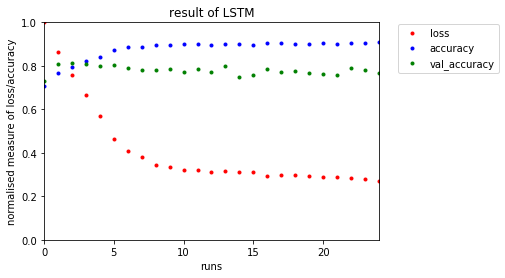

In [31]:
plt.xlabel("runs")
plt.ylabel("normalised measure of loss/accuracy")
x_len=list(range(len(acc)))
plt.axis([0, max(x_len), 0, 1])
plt.title('result of LSTM')
loss=np.asarray(loss)/max(loss)
plt.plot(x_len, loss, 'r.',label="loss")
plt.plot(x_len, acc, 'b.', label="accuracy")
plt.plot(x_len, val_acc, 'g.', label="val_accuracy")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.2)
plt.show
